# Trading strategy on real data only

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
from scipy.stats import chi2, t


In [2]:
# === Load data ===
returns = pd.read_csv('data/returns.csv', index_col=0, parse_dates=True)
regimes = pd.read_csv('data/regimes.csv', index_col=0, parse_dates=True)['Regime']
#returns = df.pct_change().dropna()

In [3]:
# === Split into train/test ===
split_idx = int(len(returns) * 0.7)
train_returns = returns.iloc[:split_idx]
test_returns = returns.iloc[split_idx:]
test_regimes = regimes.loc[test_returns.index]

### Cross-Sectional Momentum Trading Strategy 

1. **Lagged Return Ranking**
   - For each day `t`, compute asset returns from **day `t-1`**.
   - Rank all assets **cross-sectionally** based on these lagged returns (within the same day).

2. **Signal Generation**
   - Go **long** (buy) the top `long_quantile` fraction of assets (e.g., top 20%).
   - Go **short** (sell) the bottom `short_quantile` fraction of assets (e.g., bottom 20%).

3. **Portfolio Construction**
   - Assign **equal weights** within each selected group (long and short).
   - Ensure the portfolio is **dollar-neutral**, meaning the total long and short exposures are balanced.
   - **Rebalance daily** based on updated ranks.


In [4]:
def two_quantile_strategy(returns, long_quantile=0.2, short_quantile=0.2):
    """
    Cross-sectional momentum strategy:
    - Long top 'long_quantile' fraction of assets (e.g., top 20%)
    - Short bottom 'short_quantile' fraction of assets (e.g., bottom 20%)
    """
    # Use lagged returns to rank assets (to avoid lookahead bias)
    lagged = returns.shift(1)
    ranks = lagged.rank(axis=1, pct=True)  # percentiles row-wise

    # Define long and short positions
    long_mask = (ranks >= 1 - long_quantile).astype(int)
    short_mask = (ranks <= short_quantile).astype(int) * -1

    # Combine positions
    weights = long_mask + short_mask

    # Normalize weights (ensure sum of abs weights per day is 1)
    weights = weights.div(weights.abs().sum(axis=1), axis=0).fillna(0)

    # Compute daily strategy returns
    strat_returns = (weights * returns).sum(axis=1)
    return strat_returns


### Parameters

- **`long_quantile`**: fraction of top-performing assets to go long on (e.g., 0.1 to 0.3).
- **`short_quantile`**: fraction of bottom-performing assets to go short on (e.g., 0.1 to 0.3).

These two hyperparameters are calibrated jointly to maximize the **Sharpe ratio** on the training set.


In [5]:
# === Calibration metric ===
def sharpe_ratio(r):
    return r.mean() / r.std() * np.sqrt(252)

# === Grid search on train set ===
param_grid = {
    'long_quantile': np.arange(0.01, 0.3, 0.05),
    'short_quantile': np.arange(0.01, 0.3, 0.05)
}
results = []

for params in ParameterGrid(param_grid):
    r = two_quantile_strategy(train_returns, **params)
    s = sharpe_ratio(r)
    results.append((params['long_quantile'], params['short_quantile'], s))

results_df = pd.DataFrame(results, columns=['long_quantile', 'short_quantile', 'Sharpe'])
best_params = results_df.sort_values(by='Sharpe', ascending=False).iloc[0][['long_quantile', 'short_quantile']]


In [6]:
best_params

long_quantile     0.16
short_quantile    0.06
Name: 19, dtype: float64

### Evaluation Approach

- **Train/test split**: we calibrate `long_quantile` and `short_quantile` on 70% of the real data  
- **Backtest**: evaluate out-of-sample performance on the remaining 30%  
- **Regime-based analysis**: assess how the strategy performs under Bull, Bear, and Risky market conditions

Performance is measured using:

- **Sharpe ratio**  
- **Cumulative return**  
- **Max drawdown**  
- **Regime-wise statistics**


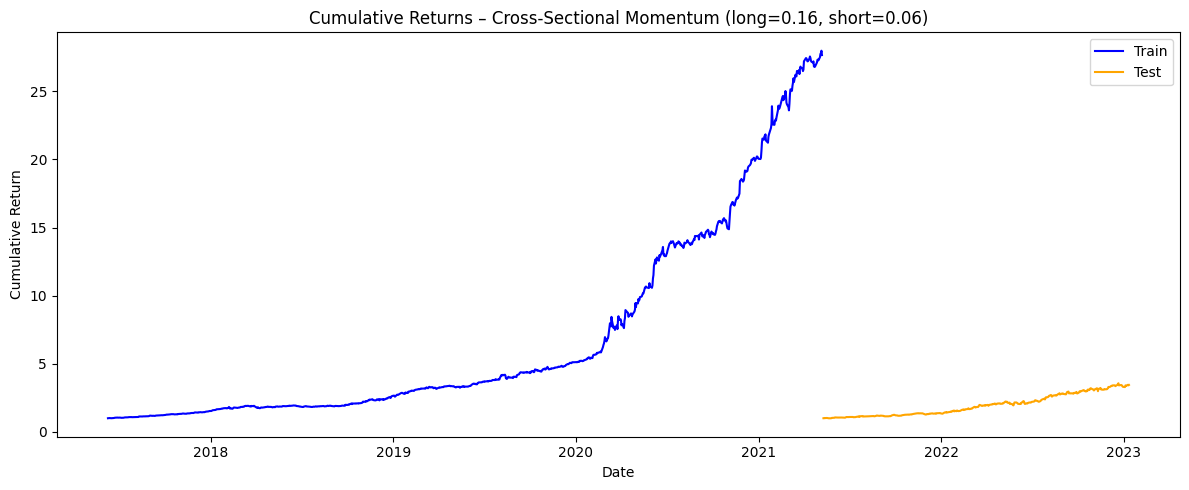

In [7]:
# === Train & test strategy using best quantiles ===
train_strategy = two_quantile_strategy(train_returns, **best_params)
test_strategy  = two_quantile_strategy(test_returns, **best_params)

# === Cumulative return plot ===
cum_train = (1 + train_strategy).cumprod()
cum_test  = (1 + test_strategy).cumprod()

long_q = best_params['long_quantile']
short_q = best_params['short_quantile']

plt.figure(figsize=(12,5))
plt.plot(cum_train, label='Train', color='blue')
plt.plot(cum_test,  label='Test',  color='orange')
plt.title(f"Cumulative Returns – Cross-Sectional Momentum (long={long_q:.2f}, short={short_q:.2f})")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
# === Global performance metrics ===
def performance_metrics(r):
    cum = (1 + r).cumprod()
    dd = cum / cum.cummax() - 1
    return pd.Series({
        'Annual Return': r.mean() * 252,
        'Annual Volatility': r.std() * np.sqrt(252),
        'Sharpe Ratio': sharpe_ratio(r),
        'Max Drawdown': dd.min()
    }).round(4)

print("=== Overall Test Performance ===")
print(performance_metrics(test_strategy))

# === Regime-wise evaluation ===
def regime_perf(r, regimes):
    df = pd.DataFrame({'r': r, 'Regime': regimes})
    grouped = df.groupby('Regime')['r'].agg(['mean','std','count'])
    grouped['Sharpe'] = grouped['mean'] / grouped['std'] * np.sqrt(252)
    return grouped.round(4)

print("\n=== Regime-wise Sharpe (Test Set) ===")
print(regime_perf(test_strategy, test_regimes))


=== Overall Test Performance ===
Annual Return        0.7697
Annual Volatility    0.2546
Sharpe Ratio         3.0237
Max Drawdown        -0.1273
dtype: float64

=== Regime-wise Sharpe (Test Set) ===
          mean    std  count  Sharpe
Regime                              
Risky   0.0031  0.016    423  3.0237


# Trading strategy on real data + augmented data in training

In [9]:
# === Load data ===
returns_aug = pd.read_csv("data/returns_augmented.csv", index_col=0, parse_dates=True)

In [10]:
# === Define real-only boundaries ===
real_returns = pd.read_csv("data/returns.csv", index_col=0, parse_dates=True)
real_index = real_returns.index
split_idx = int(len(real_index) * 0.7)

train_real_idx = real_index[:split_idx]
test_real_idx  = real_index[split_idx:]

# === Rebuild train and test ===
train_returns_aug = returns_aug.loc[~returns_aug.index.isin(test_real_idx)]  # includes real+synthetic
test_returns_real = returns_aug.loc[test_real_idx]                           # test remains real

test_regimes      = regimes.loc[test_real_idx]


In [11]:
# === Grid search calibration on extended training set ===
results_aug = []

for params in ParameterGrid(param_grid):
    r = two_quantile_strategy(train_returns_aug, **params)
    s = sharpe_ratio(r)
    results_aug.append((params['long_quantile'], params['short_quantile'], s))

results_df_aug = pd.DataFrame(results_aug, columns=['long_quantile', 'short_quantile', 'Sharpe'])
best_params_aug = results_df_aug.sort_values(by='Sharpe', ascending=False).iloc[0][['long_quantile', 'short_quantile']]


In [12]:
best_params_aug

long_quantile     0.26
short_quantile    0.16
Name: 33, dtype: float64

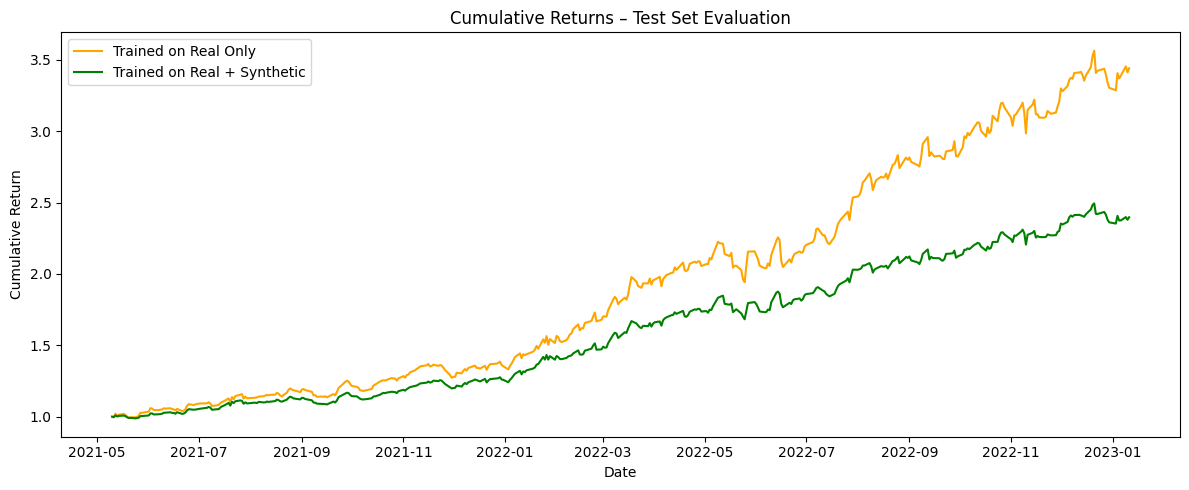

In [13]:
# === Evaluate on the same test set as before ===
test_strategy_aug = two_quantile_strategy(test_returns_real, **best_params_aug)

# === Plot cumulative returns ===
cum_test_aug = (1 + test_strategy_aug).cumprod()

plt.figure(figsize=(12,5))
plt.plot(cum_test,     label='Trained on Real Only', color='orange')
plt.plot(cum_test_aug, label='Trained on Real + Synthetic', color='green')
plt.title("Cumulative Returns – Test Set Evaluation")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
print("=== Performance on Test Set (Trained on Real + Synthetic) ===")
print(performance_metrics(test_strategy_aug))
print("\n=== Regime-wise Sharpe (Test Set) – Real+Synthetic Training ===")
print(regime_perf(test_strategy_aug, test_regimes))

=== Performance on Test Set (Trained on Real + Synthetic) ===
Annual Return        0.5373
Annual Volatility    0.1780
Sharpe Ratio         3.0178
Max Drawdown        -0.0894
dtype: float64

=== Regime-wise Sharpe (Test Set) – Real+Synthetic Training ===
          mean     std  count  Sharpe
Regime                               
Risky   0.0021  0.0112    423  3.0178


## Impact of Synthetic Data on Strategy Calibration

We compared the performance of a cross-sectional momentum strategy trained on two datasets:

- **Real data only** (70% of the original time period)
- **Real data augmented with synthetic returns** (via VAE)

Both strategies were evaluated on the **same real out-of-sample test set**, allowing a fair and controlled comparison.

### Overall Performance

The strategy trained on real data only achieved a slightly higher Sharpe ratio (**3.02 vs. 3.01**) and significantly higher annual return (**76.97% vs. 53.73%**). However, the augmented version offered better downside protection, with a **lower max drawdown** (**-8.94% vs. -12.73%**).

This suggests that while the real-only model captured more profitable signals, the augmented strategy was more conservative and resilient to large losses.

### Regime-Wise Analysis

In the Risky regime, both models achieved nearly identical Sharpe ratios (~3.02), suggesting consistent performance in volatile conditions. However, there is **no observed benefit from synthetic augmentation** in regime-specific behavior, as the regime-wise mean and volatility were both slightly lower for the augmented model.

### Conclusion

In this experiment, augmenting with synthetic data slightly **reduced performance** in terms of return and Sharpe ratio, but it **improved risk control** by reducing drawdown. These results suggest a trade-off: synthetic data may act as a regularizer that sacrifices some upside in exchange for greater stability.


# Risk evaluation (1-months α-VaR) with real data only 

In [15]:
def compute_student_t_var(returns, alpha=0.99, horizon=21, window=120):
    """
    Student-t Historical Simulation VaR on 1-month horizon:
      1. log-returns → 1-month log-return.
      2. fit Student-t on a rolling window (default 120 obs ≈ 10 yr).
      3. forecast one step ahead, back to pct-return.
    """
    log_r = np.log1p(returns)
    agg   = log_r.rolling(horizon).sum().shift(-horizon + 1)          # 1-m log-ret

    def t_q(x):
        df, loc, scale = t.fit(x)
        return t.ppf(1 - alpha, df, loc=loc, scale=scale)

    var = agg.rolling(window).apply(t_q, raw=False).shift(1)          # VaR forecast
    return np.expm1(var)   

def compute_realized_horizon_returns(returns, horizon=21):
    """Realised 1-month compound return (pct)."""
    log_r = np.log1p(returns)
    log_agg = log_r.rolling(horizon).sum().shift(-horizon + 1)
    return np.expm1(log_agg)

In [16]:
def kupiec_test(n, x, p):
    """Proportion-of-Failures (Kupiec) test."""
    if x in (0, n):
        return {"LR": np.inf, "p-value": 0.0}
    lr = -2 * (
        (n - x) * np.log(1 - p) + x * np.log(p)
        - (n - x) * np.log(1 - x/n) - x * np.log(x/n)
    )
    return {"LR": lr, "p-value": 1 - chi2.cdf(lr, df=1)}

In [17]:
def evaluate_var_forecast(returns, alpha=0.99, horizon=22,
                          label="", var_fn=compute_student_t_var):
    """
    Full VaR evaluation: compute forecasts, realised P/L, exceedances, Kupiec, plot.
    """
    var      = var_fn(returns, alpha, horizon)
    realized = compute_realized_horizon_returns(returns, horizon)

    valid    = (~var.isna()) & (~realized.isna())
    var, realized = var[valid], realized[valid]

    exceed   = realized < var
    ex_rate  = exceed.mean()
    stats    = kupiec_test(len(exceed), exceed.sum(), 1 - alpha)

    # --------- print -------
    print(f"\n=== {label} ===")
    print(f"Exceedance rate: {ex_rate:.4f}")
    print("Kupiec Test:", stats)

    # --------- plot --------
    plt.figure(figsize=(12, 5))
    plt.plot(realized.index, realized, label='Realised 1-month return')
    plt.plot(var.index, var, color='red', label=f'{int(alpha*100)} % 1-M Student-t VaR')
    plt.fill_between(realized.index, realized, var, where=exceed,
                     color='red', alpha=0.25, label='Exceedance')
    plt.title(f'{int(alpha*100)} % 1-Month VaR Forecast – {label}')
    plt.xlabel('Date');  plt.ylabel('Return')
    plt.legend();  plt.tight_layout();  plt.show()


=== Trained on Real Only ===
Exceedance rate: 0.0106
Kupiec Test: {'LR': 0.011368501416992416, 'p-value': 0.9150879325095829}


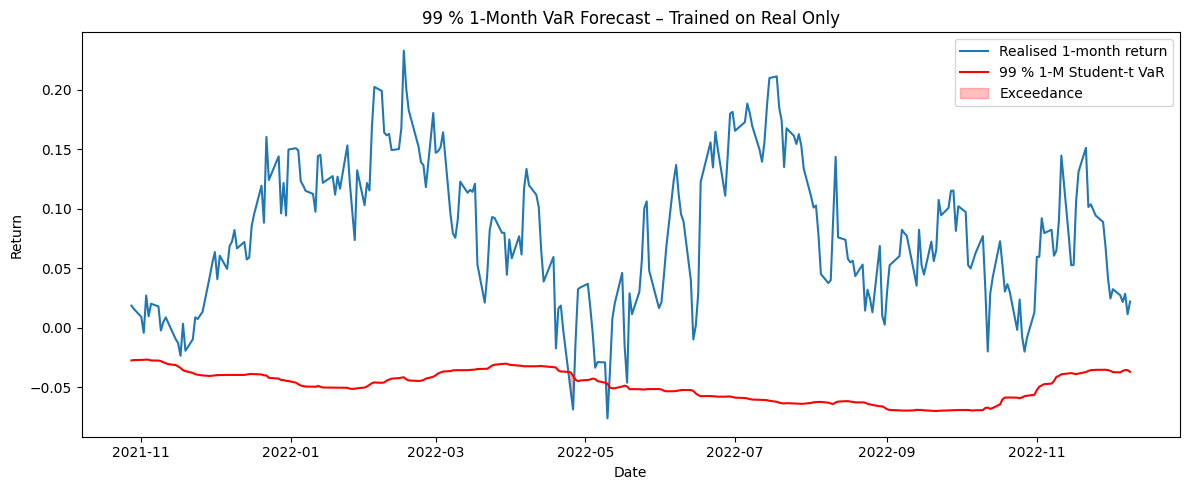

In [18]:
evaluate_var_forecast(test_strategy,     label="Trained on Real Only")

# Risk evaluation (1-months α-VaR) with real + augmented data in training


=== Trained on Real + Synthetic ===
Exceedance rate: 0.0106
Kupiec Test: {'LR': 0.011368501416992416, 'p-value': 0.9150879325095829}


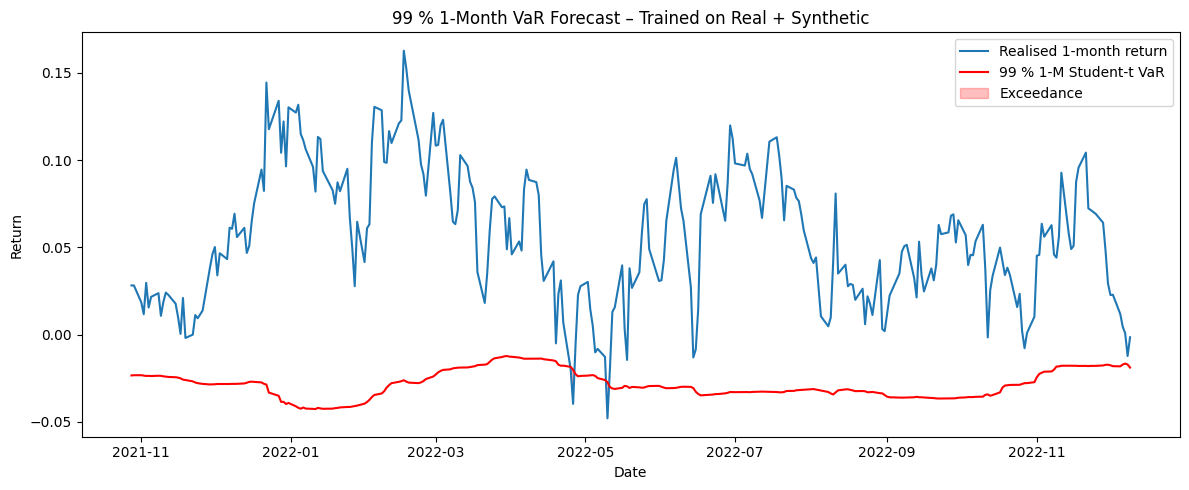

In [19]:
evaluate_var_forecast(test_strategy_aug, label="Trained on Real + Synthetic")

both are well calibrated and we get same result because we have the same number of breaches